In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cart2sph(cart):
	xy2 = cart[:,0]**2 + cart[:,1]**2
	sph = np.zeros_like(cart)
	sph[:,0] = np.sqrt(xy2 + cart[:,2]**2)
	sph[:,1] = np.arctan2(np.sqrt(xy2), cart[:,2]) # Elevation angle defined from Z-axis down
	sph[:,2] = np.arctan2(cart[:,1], cart[:,0])
	return sph

In [3]:
def block_doa(frm_val, block_size):
    n_blocks = frm_val.shape[1]// block_size + 1

    blk_doas = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):

        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + frm_val.shape[1]

        blk_sum = torch.sum(frm_val[:,blk_start:blk_end],dim=1)
        blk_doa_idx = torch.argmax(blk_sum)
        blk_doa = blk_doa_idx

        blk_start = blk_end

        blk_doas.append(blk_doa)

    return blk_doas

#for now taking absolute inside the block
def block_lbl_doa(lbl_doa, block_size):
    #assuming lbl_doa [r, elv, azi] : (1, frms, 3)
    n_blocks = lbl_doa.shape[1]// block_size + 1

    blk_doas = []
    blk_range = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):
        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + lbl_doa.shape[1]

        blk_doa = torch.mean(torch.abs(lbl_doa[:,blk_start:blk_end, : ]),dim=1)

        blk_start = blk_end
        blk_doas.append(torch.rad2deg(blk_doa[:,2])) # azimuth
        blk_range.append(blk_doa[:,0]) # range

    return blk_doas, blk_range


def blk_vad(frm_level_vad, block_size):
    #assuming frm_level_vad : (frms)
    n_blocks = frm_level_vad.shape[0]// block_size + 1

    frm_level_vad = 1.0*frm_level_vad
    blk_vads = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):
        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + frm_level_vad.shape[0]

        _blk_vad = torch.mean(frm_level_vad[blk_start:blk_end])

        blk_start = blk_end
        blk_vads.append(_blk_vad)
    return blk_vads


In [4]:
tol = 5

def get_acc(est_vad, est_blk_val, tgt_blk_val, tol=5):
    n_blocks = len(est_vad)
    non_vad_blks =[]
    acc=0
    valid_blk_count = 0
    for idx in range(0, n_blocks):
        if est_vad[idx] >=0.98:
            if (np.abs(est_blk_val[idx] - np.abs(tgt_blk_val[idx])) <= tol):
                acc += 1
            valid_blk_count +=1
        else:
            non_vad_blks.append(idx)

    acc /= valid_blk_count
    
    print(f'n_blocks: {n_blocks}, non_vad_blks: {non_vad_blks}')
    return acc



In [5]:
scenario = "source_moving"
snr =  -5
t60 = 0.2
src_mic_dist = 1.0
noi_mic_dist = 1.0

idx=2
#read the config file
#
file_path = f'../test_dataset_file_circular_motion_snr_{snr}_t60_{t60}.txt' #dataset_file_10sec.txt'

with open(file_path) as f:
    configs_lst = [line.strip().split(',')[-1] for line in f.readlines()]


config_file = configs_lst[idx]

cfg = torch.load(config_file)

config_dict = cfg #circular_motion_config_dict
room_sz = config_dict['room_sz']
mic_pos = config_dict['mic_pos']
traj_pts= config_dict['src_traj_pts']
noise_pos= config_dict['noise_pos']
T60= config_dict['t60']
SNR= config_dict['snr']

noise_pos =  np.expand_dims(noise_pos, axis=0) if len(noise_pos.shape) == 1 else noise_pos


array_pos = np.mean(mic_pos, axis=0, keepdims=True)
noise_spherical = cart2sph(noise_pos-array_pos)

#range motion of source
print(f' Noise range: {noise_spherical[:,0]}, elevation: {np.degrees(noise_spherical[:,1])}, azimuth : {np.degrees(noise_spherical[:,2]) }')


mix_t60_lst = []
est_t60_lst = []
mvng_t60_lst = []

mix_frm_t60_lst = []
est_frm_t60_lst = []
mvng_frm_t60_lst = []

for t60 in [0.2]:
    mix_avg_lst = []
    est_avg_lst = []
    mvng_avg_lst = []
    
    mix_frm_avg_lst = []
    est_frm_avg_lst = []
    mvng_frm_avg_lst = []
    pp_str = f'../signals/{scenario}/from_dataset_circular_motion_snr_{snr}_t60_{t60}_src_mic_dist_{src_mic_dist}_noi_mic_dist_{noi_mic_dist}/'  #from_dataset_file_10sec/v2/'
    for batch_idx in range(idx, idx+1):
        app_str = f'{batch_idx}'

        #app_str = f'sp_{static_prob}_nlp_{non_linear_motion_prob}_snr_{test_snr}_t60_{test_t60}_nb_points_{nb_points}'

        info = torch.load(f'{pp_str}doa_{app_str}.pt')

        (mix_f_doa, mix_f_vals, mix_sig_vad, mix_utt_doa, mix_utt_sum) = info['mix']
        (tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa, tgt_utt_sum) = info['tgt']
        (est_f_doa, est_f_vals, est_sig_vad, est_utt_doa, est_utt_sum) = info['est']
        (mvng_est_f_doa, mvng_est_f_vals, mvng_est_sig_vad, mvng_est_utt_doa, mvng_est_utt_sum) = info['mvng_est']
        lbl_doa = info['lbl_doa']


        mix_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(tgt_f_doa))
        est_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(tgt_f_doa))
        mvng_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mvng_est_f_doa), np.array(tgt_f_doa))


        mix_frm_avg_lst.append(mix_frm_Acc)
        est_frm_avg_lst.append(est_frm_Acc)
        mvng_frm_avg_lst.append(mvng_frm_Acc)
        

        blk_size = 25
        mix_blk_vals = block_doa(frm_val=mix_f_vals, block_size=blk_size)
        tgt_blk_vals = block_doa(frm_val=tgt_f_vals, block_size=blk_size)
        est_blk_vals = block_doa(frm_val=est_f_vals, block_size=blk_size)
        mvng_est_blk_vals = block_doa(frm_val=mvng_est_f_vals, block_size=blk_size)

        lbl_blk_doa, lbl_blk_range = block_lbl_doa(lbl_doa, block_size=blk_size)

        mix_blk_vad = blk_vad(mix_sig_vad, blk_size)
        tgt_blk_vad = blk_vad(tgt_sig_vad, blk_size)
        est_blk_vad = blk_vad(est_sig_vad, blk_size)
        mvng_blk_vad = blk_vad(mvng_est_sig_vad, blk_size)

        mix_Acc = get_acc(np.array(tgt_blk_vad), np.array(mix_blk_vals), np.array(tgt_blk_vals))
        est_Acc = get_acc(np.array(tgt_blk_vad), np.array(est_blk_vals), np.array(tgt_blk_vals))
        mvng_est_Acc = get_acc(np.array(tgt_blk_vad), np.array(mvng_est_blk_vals), np.array(tgt_blk_vals))

        mix_avg_lst.append(mix_Acc)
        est_avg_lst.append(est_Acc)
        mvng_avg_lst.append(mvng_est_Acc)
    
    mix_t60_lst.append(np.mean(np.array(mix_avg_lst)))
    est_t60_lst.append(np.mean(np.array(est_avg_lst)))
    mvng_t60_lst.append(np.mean(np.array(mvng_avg_lst)))

    
    mix_frm_t60_lst.append(np.mean(np.array(mix_frm_avg_lst)))
    est_frm_t60_lst.append(np.mean(np.array(est_frm_avg_lst)))
    mvng_frm_t60_lst.append(np.mean(np.array(mvng_frm_avg_lst)))

 Noise range: [1.], elevation: [90.], azimuth : [106.]
n_blocks: 398, non_vad_blks: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
n_blocks: 398, non_vad_blks: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
n_blocks: 398, non_vad_blks: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
n_blocks: 16, non_vad_blks: [0, 1]
n_blocks: 16, non_vad_blks: [0, 1]
n_blocks: 16, non_vad_blks: [0, 1]


In [6]:
mix_Acc, est_Acc, mvng_est_Acc, mix_frm_Acc, est_frm_Acc, mvng_frm_Acc

(0.07142857142857142,
 0.42857142857142855,
 0.5,
 0.13404825737265416,
 0.27882037533512066,
 0.28418230563002683)

In [7]:
info['mix_metrics'], info['est_metrics'], info['mvng_est_metrics']

({'snr': -5.130601201630472,
  'si_snr': -5.3124505015825845,
  'pesq_nb': 1.3265853457878802,
  'pesq_wb': 1.020091528560431,
  'stoi': 0.605847117493291,
  'e_stoi': 0.35614004813406014},
 {'snr': 1.444107137850494,
  'si_snr': 0.46602025395079777,
  'pesq_nb': 1.7002648626191286,
  'pesq_wb': 1.0342803545736239,
  'stoi': 0.7118510461965174,
  'e_stoi': 0.5100052642801048},
 {'snr': 1.7212857964997341,
  'si_snr': 0.9363757027060458,
  'pesq_nb': 1.755599013133626,
  'pesq_wb': 1.039709324406556,
  'stoi': 0.7205313700045699,
  'e_stoi': 0.5118070277578602})

In [8]:
src_azimuth = np.degrees(cart2sph(traj_pts-array_pos)[:,2])
src_azimuth_keys = np.round(np.where(src_azimuth<0, 360+src_azimuth, src_azimuth)).astype('int32')	

In [9]:
src_azimuth, src_azimuth_keys, src_azimuth_keys-180

(array([-81., -76., -71., -66., -60., -55., -50., -45., -40., -35., -30.,
        -25., -19., -14.,  -9.,  -4.]),
 array([279, 284, 289, 294, 300, 305, 310, 315, 320, 325, 330, 335, 341,
        346, 351, 356], dtype=int32),
 array([ 99, 104, 109, 114, 120, 125, 130, 135, 140, 145, 150, 155, 161,
        166, 171, 176], dtype=int32))

In [10]:
mvng_est_blk_vals

[tensor(73),
 tensor(106),
 tensor(108),
 tensor(111),
 tensor(123),
 tensor(70),
 tensor(131),
 tensor(132),
 tensor(72),
 tensor(146),
 tensor(158),
 tensor(72),
 tensor(71),
 tensor(164),
 tensor(67),
 tensor(71)]

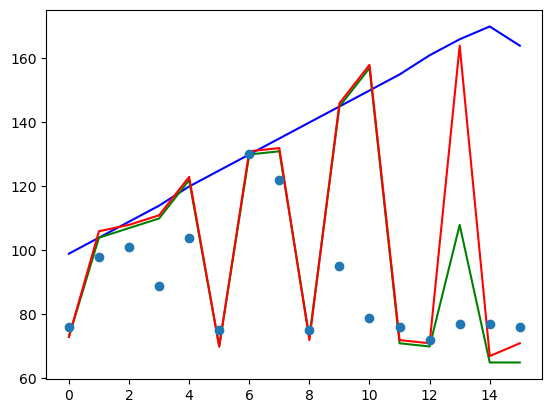

In [11]:
plt.figure()
plt.plot(tgt_blk_vals,'b')
plt.plot(est_blk_vals,'g')
plt.plot(mvng_est_blk_vals,'r')
plt.plot(mix_blk_vals, 'o')
#plt.plot(src_azimuth, 'b+')

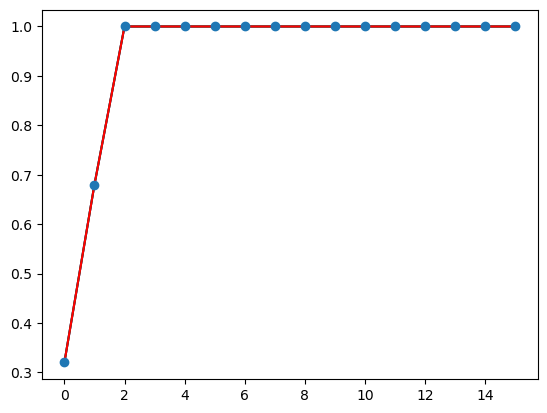

In [12]:
plt.figure()
plt.plot(tgt_blk_vad,'b')
plt.plot(est_blk_vad,'g')
plt.plot(mvng_blk_vad,'r')
plt.plot(mix_blk_vad, 'o')